In [1]:
env XLA_PYTHON_CLIENT_MEM_FRACTION=0.25

env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.25


In [17]:
import renn
import matplotlib.pyplot as plt

In [13]:
import tensorflow_datasets as tfds
import jax
import jax.numpy as jnp

from jax.experimental import stax, optimizers

import numpy as np

from renn.losses import multiclass_xent

from tqdm import tqdm
from functools import partial
from renn import serialize

from data_processing import analysis_utils as au

In [19]:
vocab_file='./data/vocab/ag_news.vocab'

seq_length = 160
num_classes = 4

def filter_fn(item):
    return item['labels'] < num_classes

# Load data
train_dset = renn.data.ag_news('train', vocab_file, sequence_length=seq_length, data_dir='./data', filter_fn=filter_fn)
test_dset = renn.data.ag_news('test', vocab_file, sequence_length=seq_length, data_dir='./data', filter_fn=filter_fn)

# Load vocab
with open(vocab_file, 'r') as f:
    vocab = f.readlines()
vocab_size = len(vocab)

example = next(iter(train_dset))

In [20]:
def SequenceSum():
    def init_fun(_, input_shape):
        return (input_shape[0], input_shape[2]), ()
    def apply_fun(_, inputs, **kwargs):
        return jnp.sum(inputs, axis=1)
    return init_fun, apply_fun

In [21]:
emb_size = 32

input_shape = (-1, seq_length)
l2_pen = 0

# Linear model
init_fun, apply_fun = stax.serial(
    renn.embedding(vocab_size, emb_size),
    SequenceSum(),
    stax.Dense(num_classes),
    )

# Initialize
key = jax.random.PRNGKey(0)
output_shape, initial_params = init_fun(key, input_shape)

# Hack to set the embedding to 0 for 0
emb = initial_params[0]
new_emb = np.array(emb)
new_emb[0] = np.zeros(emb_size)
initial_params = [jnp.array(new_emb), *initial_params[1:]]

# Loss
def xent(params, batch):
    logits = apply_fun(params, batch['inputs'])
    data_loss = multiclass_xent(logits, batch['labels'])
    reg_loss = l2_pen * renn.norm(params)
    return data_loss + reg_loss

f_df = jax.value_and_grad(xent)

# Accuracy
@jax.jit
def accuracy(params, batch):
    logits = apply_fun(params, batch['inputs'])
    predictions = jnp.argmax(logits, axis=1)
    return jnp.mean(predictions == batch['labels'])



In [22]:
learning_rate = optimizers.exponential_decay(2e-3, 1000, 0.8)
init_opt, update_opt, get_params = optimizers.adam(learning_rate)

state = init_opt(initial_params)
losses = []

@jax.jit
def step(k, opt_state, batch):
    params = get_params(opt_state)
    loss, gradients = f_df(params, batch)
    new_state = update_opt(k, gradients, opt_state)
    return new_state, loss

def test_acc(params):
    return jnp.array([accuracy(params, batch) for batch in tfds.as_numpy(test_dset)])

In [23]:
for epoch in range(1):
    print('=====================================')
    print(f'== Epoch #{epoch}')
    p = get_params(state)
    acc = np.mean(test_acc(p))
    print(f'== Test accuracy: {100. * acc:0.2f}%')
    print('=====================================')
    
    for batch in tfds.as_numpy(train_dset):
        k = len(losses)
        state, loss = step(k, state, batch)
        losses.append(loss)

        if k % 100 == 0:
            p = get_params(state)
            print(f'[step {k}]\tLoss: {np.mean(losses[k-100:k]):0.4f}', flush=True)
            
print('=====================================')
print(f'== Epoch #{epoch}')
p = get_params(state)
acc = np.mean(test_acc(p))
print(f'== Test accuracy: {100. * acc:0.2f}%')
print('=====================================')

== Epoch #0
== Test accuracy: 24.27%
[step 0]	Loss: nan


/usr/local/google/home/ramasesh/VirtualEnvs/dyn/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/google/home/ramasesh/VirtualEnvs/dyn/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[step 100]	Loss: 0.7555
[step 200]	Loss: 0.4190
[step 300]	Loss: 0.3474
[step 400]	Loss: 0.3391
[step 500]	Loss: 0.3415
[step 600]	Loss: 0.3212
[step 700]	Loss: 0.3298
[step 800]	Loss: 0.3076
[step 900]	Loss: 0.3201
[step 1000]	Loss: 0.3106
[step 1100]	Loss: 0.2963
[step 1200]	Loss: 0.2813
[step 1300]	Loss: 0.2800
[step 1400]	Loss: 0.3025
[step 1500]	Loss: 0.2885
[step 1600]	Loss: 0.2762
[step 1700]	Loss: 0.2679
[step 1800]	Loss: 0.2882
== Epoch #0
== Test accuracy: 90.55%


In [24]:
params = get_params(state)

In [25]:
def delta_logit(vocab_index, params):
    test_batch = jnp.zeros((2, 160), dtype = jnp.int64)
    test_batch = jax.ops.index_update(test_batch, jax.ops.index[1,0], vocab_index)
    
    logits = apply_fun(params, test_batch)
    return logits[1] - logits[0]

In [26]:
delta_logit(151, params)

/usr/local/google/home/ramasesh/VirtualEnvs/dyn/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


DeviceArray([-0.73290765, -1.1317863 ,  0.3733107 ,  1.0910239 ], dtype=float32)

In [27]:
with open('test','wb') as f:
    serialize.dump(np.array(params), f)

ValueError: Object and structured dtypes are not supported.

### Logit-changes PCA

In [28]:
num_words = 300

In [29]:
most_common_words = np.arange(num_words).reshape(1,-1).T
output_logits = {'initial': apply_fun(initial_params, most_common_words),
                 'final': apply_fun(p, most_common_words)}

In [30]:
f = lambda x: x[1:] - x[0]
logit_changes = {k: f(v) for k,v in output_logits.items()}

In [31]:
PCA_obj = {k: au.PCA_rnn() for k in output_logits.keys()}

for k in output_logits.keys():
    PCA_obj[k].fit(logit_changes[k])

In [32]:
dimensionalities = {k: au.cumulative_var_explained(PCA_obj[k]) for k in PCA_obj.keys()}

(-1.0, 5.0)

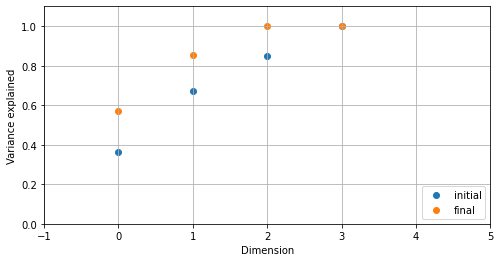

In [33]:
f = au.plot_varexp(dimensionalities)
plt.xlim(-1,5)

(array([0.02339176, 0.        , 0.        , 0.        , 0.21052576,
        0.46783501, 1.75438147, 2.59648431, 1.1461959 , 0.37426801,
        0.16374229, 0.07017524, 0.09356702, 0.        , 0.07017524,
        0.        , 0.        , 0.        , 0.        , 0.02339175]),
 array([-1.0593817 , -0.9164048 , -0.7734278 , -0.63045084, -0.48747388,
        -0.3444969 , -0.20151994, -0.05854298,  0.08443399,  0.22741094,
         0.3703879 ,  0.51336485,  0.65634185,  0.7993188 ,  0.9422958 ,
         1.0852728 ,  1.2282497 ,  1.3712267 ,  1.5142037 ,  1.6571805 ,
         1.8001575 ], dtype=float32),
 <BarContainer object of 20 artists>)

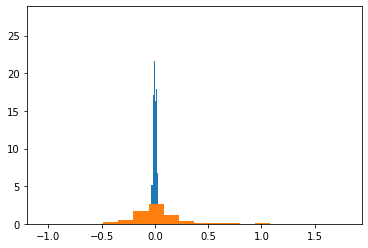

In [41]:
plt.hist(logit_changes['initial'].sum(axis=1), bins=20, density=True)
plt.hist(logit_changes['final'].sum(axis=1), bins=20, density=True)